In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import flopy
import pyemu
import swatmf
import matplotlib.pyplot as plt

### Versions:
swatmf=1.0.1; numpy=2.4.0; pandas=2.3.3; pyemu=1.3.8; flopy=3.9.5

In [2]:
from swatmf import swatmf_pst_utils, swatmf_pst_par

In [3]:
swatmf.__version__

'1.0.1'

In [4]:
pd.__version__

'3.0.0'

# 1. Set up 
## 1.1 write swatmf.con file

In [5]:
# working directory
prj_dir = r"C:\Users\gyc22\Downloads\New SWAT MODFLOW\pest\main_opt"
swatmf_model = r"C:\Users\gyc22\Downloads\New SWAT MODFLOW\pest\SWAT-MODFLOW"
swat_model = r"C:\Users\gyc22\Downloads\New SWAT MODFLOW\pest\SWAT"

In [6]:
# working directory and file names
# calibration period
sim_start = '1/1/2005'
warmup = 3
cal_start = '1/1/2008'
cal_end = '12/31/2014'

# time step
time_step = 'day'

# extract simulation (what our targets)
# locations
subs = [1]
grids = [5163]

## 1.2 Initiate PEST

In [7]:
# copy all necessary files (exes) to your working direcotry
swatmf_pst_utils.init_setup(prj_dir, swatmf_model, swat_model)

 Creating 'main_opt' folder in working directory ...

100%|█████████████████████████████████████████████████████████████████████████████| 1512/1512 [00:02<00:00, 709.07it/s]

 Creating 'main_opt' folder ... passed
 Creating 'backup' folder ...


0it [00:00, ?it/s]

 Creating 'backup' folder ... passed
 'Absolute_SWAT_Values.txt' file copied ... passed
 'i64pwtadj1.exe' file copied ... passed
 'pestpp-glm.exe' file copied ... passed
 'pestpp-ies.exe' file copied ... passed
 'pestpp-opt.exe' file copied ... passed
 'pestpp-sen.exe' file copied ... passed
 'swat_pars.db.csv' file copied ... passed
 'swatmf_rel230922.exe' file copied ... passed
 'forward_run.py' file copied ... passed


In [8]:
swatmf_pst_utils.create_swatmf_con(
    prj_dir, swatmf_model, sim_start, warmup, cal_start, cal_end, subs=subs, grids=grids)

,names,vals
0,prj_dir,C:\Users\gyc22\Downloads\New SWAT MODFLOW\pest\main_opt
1,swatmf_model,C:\Users\gyc22\Downloads\New SWAT MODFLOW\pest\SWAT-MODFLOW
2,sim_start,1/1/2005
3,warm-up,3
4,cal_start,1/1/2008
5,cal_end,12/31/2014
6,subs,[1]
7,grids,[5163]
8,riv_parm,n
9,baseflow,n


# 2. Build template files

## 2.1 MODFLOW parameters with Pilot Points

In [9]:
# SET PATH to your optimization working folder
main_opt = "C:\\Users\\gyc22\\Downloads\\New SWAT MODFLOW\\pest\\main_opt\\main_opt"

### Set up zones for where pilot points will be interpolated

We can have pilot point networks in multiple zones. In this case, we will make a simple zone file using `IDOMAIN` such that all active cells are in the same interpolation zone.

In [10]:
mname = 'modflow.mfn'
m = flopy.modflow.Modflow.load(
    mname, model_ws=main_opt)

C:\Users\gyc22\Documents\swat\swatmf_wf\dependencies\flopy\flopy\mbase.py:105: UserWarning: The program mf2005 does not exist or is not executable.


<Axes: title={'center': 'ibound_layer_0'}>

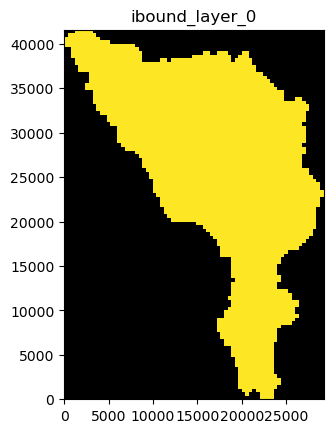

In [11]:
m.bas6.ibound[0].plot()

### Get the model spatial reference
We need to get information on the model grid so that `pyemu` can set up interpolation from pilot points to the model cells:

In [12]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(main_opt, mname),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

We are going to use a `pyemu` helper function to setup pilot points at cell centers for active cells:

In [13]:
#START OF EXAMPLE CELLS
#THIS IS EXAMPLE AND LATER INCLUDED IN THE LOOP, NO NEED TO RUN THIS CELL
# Create pilot points as a shapefile
# we want hk pilot points in the top layer...
parName= "hk0"
prefix_dict = {0:[f"{parName}"]}
df_pp = pyemu.pp_utils.setup_pilotpoints_grid(
                                                # ml=m,
                                                sr = sr,
                                              prefix_dict=prefix_dict,
                                              pp_dir=main_opt,
                                              tpl_dir=main_opt,
                                              every_n_cell=10,
                                              shapename=f'pp_{parName}.shp')
pp_file = os.path.join(main_opt,f"{parName}pp.dat")
# assert os.path.exists(pp_file)

ibound not passed, using array of ones


Exception: unrecognized field type in par_info:name:str

In [17]:
df_pp

,name,x,y,zone,parval1,k,i,j,parnme,tpl,tpl_filename,pp_filename,pargp,dercom,offset,parchglim,parlbnd,partrans,parubnd,scale
0,pp_0000,5500.0,17500.0,1,1.0,0,5,5,hk0_i:5_j:5_zone:1,~ hk0_i:5_j:5_zone:1 ~,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat.tpl,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat,hk0,1,0.0,factor,1.100000e-10,log,1.100000e+10,1.0
1,pp_0001,15500.0,17500.0,1,1.0,0,5,15,hk0_i:5_j:15_zone:1,~ hk0_i:5_j:15_zone:1 ~,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat.tpl,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat,hk0,1,0.0,factor,1.100000e-10,log,1.100000e+10,1.0
2,pp_0002,25500.0,17500.0,1,1.0,0,5,25,hk0_i:5_j:25_zone:1,~ hk0_i:5_j:25_zone:1 ~,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat.tpl,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat,hk0,1,0.0,factor,1.100000e-10,log,1.100000e+10,1.0
3,pp_0003,35500.0,17500.0,1,1.0,0,5,35,hk0_i:5_j:35_zone:1,~ hk0_i:5_j:35_zone:1 ~,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat.tpl,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat,hk0,1,0.0,factor,1.100000e-10,log,1.100000e+10,1.0
4,pp_0004,5500.0,7500.0,1,1.0,0,15,5,hk0_i:15_j:5_zone:1,~ hk0_i:15_j:5_zone:1 ~,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat.tpl,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat,hk0,1,0.0,factor,1.100000e-10,log,1.100000e+10,1.0
5,pp_0005,15500.0,7500.0,1,1.0,0,15,15,hk0_i:15_j:15_zone:1,~ hk0_i:15_j:15_zone:1 ~,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat.tpl,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat,hk0,1,0.0,factor,1.100000e-10,log,1.100000e+10,1.0
6,pp_0006,25500.0,7500.0,1,1.0,0,15,25,hk0_i:15_j:25_zone:1,~ hk0_i:15_j:25_zone:1 ~,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat.tpl,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat,hk0,1,0.0,factor,1.100000e-10,log,1.100000e+10,1.0
7,pp_0007,35500.0,7500.0,1,1.0,0,15,35,hk0_i:15_j:35_zone:1,~ hk0_i:15_j:35_zone:1 ~,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat.tpl,C:\Users\spark\Documents\kj_opt\main_opt\hk0pp.dat,hk0,1,0.0,factor,1.100000e-10,log,1.100000e+10,1.0


So cool, we now defined pilot points as a set of spatially distributed parameters...but how do go from pilot points to the model input HK array? Answer: geostatistics.  

We need to calculate the geostatistical factors (weights) used to form the interpolated value for the HK value at each model cell - its a spatially-weighted combination of pilot point values

If you are not familiar or are rusty on geostatistics, consider checking out the [`intro_to_geostatistics`](https://github.com/gmdsi/GMDSI_notebooks/blob/main/tutorials/part0_intro_to_geostatistics/intro_to_geostatistics.ipynb) notebook 

## Need to create Kriging factors and regularization inputs
Following the guidelines in _Approaches to Highly Parameterized Inversion: Pilot-Point Theory, Guidelines, and Research Directions_ https://pubs.usgs.gov/sir/2010/5168/

### First we need to define a couple geostatistical structures (e.g. variograms)

From _PEST Groundwater Data Utilities Part A: Overview_ page 43, there are 4 acceptable variogram types:

 1. *Spherical*  
### $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
### $\gamma\left(h\right)=c$ if $h \ge a$  
     
 2. *Exponential*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
     
 3. *Gaussian*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  
 
 4. *Power*  
### $\gamma\left(h\right)=c\times h^a$
     
 The number refers to `VARTYPE`. 
 
 `BEARING` and `ANISOTROPY` only apply if there is a principal direction of anisotropy. 
 
 $h$ is the separation distance, and $a$ is the range, expressed with the `A` parameter.


### First, let's create ``variogram`` and ``GeoStruct`` objects.  

These describe how HK varies spatailly, remember?

In [19]:
pyemu.geostats.GeoStruct?

Init signature:
pyemu.geostats.GeoStruct(
    nugget=0.0,
    variograms=[],
    name='struct1',
    transform='none',
)
Docstring:     
a geostatistical structure object that mimics the behavior of a PEST
geostatistical structure.  The object contains variogram instances and
(optionally) nugget information.

Args:
    nugget (`float` (optional)): nugget contribution. Default is 0.0
    variograms : ([`pyemu.Vario2d`] (optional)): variogram(s) associated
        with this GeoStruct instance. Default is empty list
    name (`str` (optional)): name to assign the structure.  Default
        is "struct1".
    transform  (`str` (optional)): the transformation to apply to
        the GeoStruct.  Can be "none" or "log", depending on the
        transformation of the property being represented by the `GeoStruct`.
        Default is "none"

Example::

    v = pyemu.utils.geostats.ExpVario(a=1000,contribution=1.0)
    gs = pyemu.utils.geostats.GeoStruct(variograms=v,nugget=0.5)
    gs.plot()
   

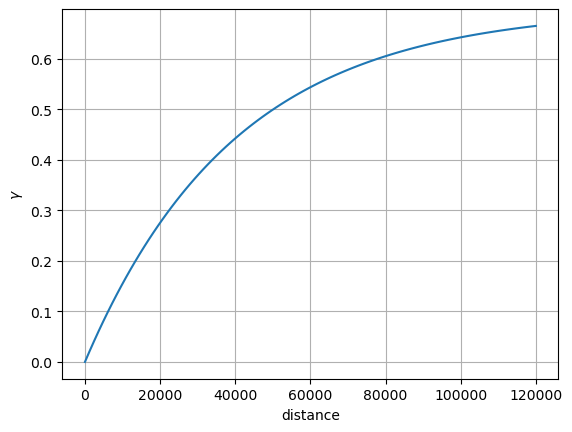

In [25]:
v = pyemu.geostats.ExpVario(contribution=0.7,a=40000)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0, transform="log")
ax = gs.plot()
ax.grid()
# ax.set_ylim(0,2.0)

Now, let's get an ``OrdinaryKrige`` object, which needs the ``GeoStruct`` as well as the x, y, and name of the pilot point locations (which happens to be in that really cool ``df_pp`` instance)

In [26]:
ok = pyemu.geostats.OrdinaryKrige(gs,df_pp)

In [27]:
os.getcwd()

'C:\\Users\\spark\\Documents\\kj_opt\\main_opt'

Once the ``OrdinaryKrige`` object is created, we need to calculate the geostatistical interpolation factors for each model cell.  We do this with the ``.calc_factors_grid()`` method: it needs to know about the model's spatial orientation and also accepts some optional arguments:

In [28]:
#NO NEED TO RUN THIS CELL, THIS IS JUST EXAMPLE, IT IS INCLUDED LATER IN THE LOOP
df = ok.calc_factors_grid(
            sr,
            var_filename= f"{parName}pp.var.ref",
            minpts_interp=1,
            maxpts_interp=10,
            search_radius=20000,
            verbose=True,
            num_threads=12
)

starting interp point loop for 920 points
starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9
starting 10
starting 11
took 2.771888 seconds


One of the really cool things about geostatistics is that it gives you both the interpolation (factors), but also gives you the uncertainty in the areas between control (pilot) points.  Above, we wrote this uncertainty information to an array that has the same rows and cols as the model grid - this array is very useful for understanding the function of the variogram.

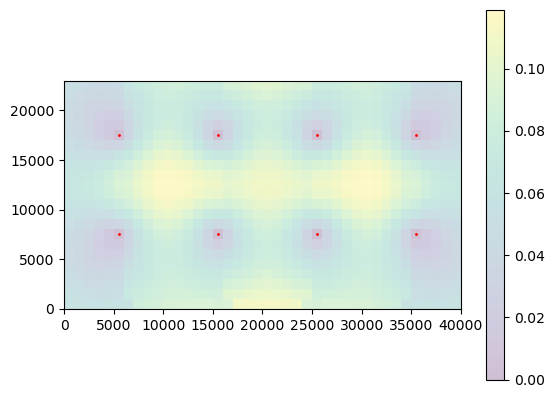

In [29]:
#NO NEED TO RUN THIS CELL, THIS IS JUST EXAMPLE, IT IS INCLUDED LATER IN THE LOOP
# arr_var = np.loadtxt(pst_name.replace(".pst",".var.ref"))
arr_var = np.loadtxt(f"{parName}pp.var.ref")
ax = plt.subplot(111,aspect="equal")
p = ax.imshow(arr_var,extent=sr.get_extent(),alpha=0.25)
plt.colorbar(p)
ax.scatter(df_pp.x,df_pp.y,marker='.',s=4,color='r')
#END OF EXAMPLE CELLS

We see that at the pilot point locations (red dots), the uncertainty in the geostats is minimal...as expected. The color scale is uncertainty. It increases with distance to pilot points.

The call to ``.calc_factors_grid()`` also returns a ``DataFrame`` which has useful info - lets look:

In [31]:
df.head()

,x,y,idist,inames,ifacts,err_var
0,500.0,22500.0,"[7071.067811865475, 15811.388300841896, 15811.388300841896]","[pp_0000, pp_0001, pp_0004]","[0.806739318840126, 0.09663034057993702, 0.096630340579937]",0.052175
1,1500.0,22500.0,"[6403.1242374328485, 14866.068747318506, 15524.174696260025]","[pp_0000, pp_0001, pp_0004]","[0.8191098319198504, 0.10933762306222686, 0.07155254501792271]",0.049147
2,2500.0,22500.0,"[5830.951894845301, 13928.38827718412, 15297.058540778355]","[pp_0000, pp_0001, pp_0004]","[0.8003895324340959, 0.13843691369951758, 0.06117355386638659]",0.043385
3,3500.0,22500.0,"[5385.164807134504, 13000.0, 15132.745950421557]","[pp_0000, pp_0001, pp_0004]","[0.800715866140528, 0.16069824496422058, 0.0385858888952512]",0.042448
4,4500.0,22500.0,"[5099.019513592785, 12083.045973594571, 15033.296378372908]","[pp_0000, pp_0001, pp_0004]","[0.7915063078778363, 0.18985408185363487, 0.018639610268528853]",0.043316


We see that there is one row for each model cell, and for each row, we see the distance, names, and weight for the "nearby" pilot points.  The interpolated value for cells that have a pilot point at their center only need one weight - 1.0 - and one pilot point.  Other cells are weighted combinations of pilot points. 

### Back to linking pilot points to grid values

Now we need to save the factors (weights) to a special file that we will use later to quickly generate a new HK array from a set of pilot point values:

In [32]:
ok.to_grid_factors_file(pp_file+".fac")

Just for demo purposes, let's generate ``random`` pilot point values and run them through the factors to see what the ``hk`` array looks like

In [33]:
# generate random values

df_pp.loc[:,"parval1"] = np.random.randint(0.1, 100, size=df_pp.shape[0])
# fixedvals = [1, 10, 10, 90, 90, 20, 50, 30, 70]
# df_pp.loc[:,"parval1"] = fixedvals
# save a pilot points file
pyemu.pp_utils.write_pp_file(pp_file,df_pp)

In [34]:
# interpolate the pilot point values to the grid
hk_arr = pyemu.geostats.fac2real(pp_file, factors_file=pp_file+".fac",out_file=None, )

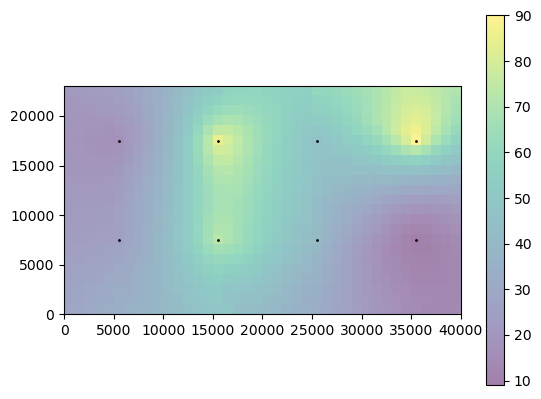

In [35]:
# plot
ax = plt.subplot(111,aspect='equal')
p = ax.imshow(hk_arr,interpolation="nearest",extent=sr.get_extent(),alpha=0.5)
plt.colorbar(p)
ax.scatter(df_pp.x,df_pp.y,marker='.',s=4,color='k')


What happens if you recalculate the factors using one point for every cell? Change ``maxpts_interp`` to 1 in the ``calc_factors_grid()`` and rerun these cells.

### (Foreshadowing) An aside on geostatistics and covariance matrices

The ``GeoStruct`` object above was used to interpolate from pilot point locations to each node in the grid.  But this same ``GoeStruct`` also has important information regarding how the pilot points are related to each other spatially---that is, the ``GeoStruct`` object implies a covariance matrix.  Let's form that matrix 

In [36]:
cov = gs.covariance_matrix(df_pp.x,df_pp.y,df_pp.parnme)

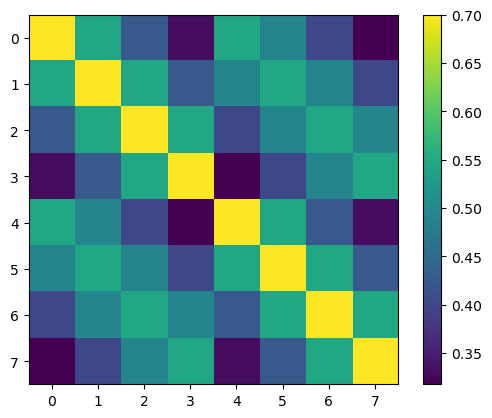

In [37]:
plt.imshow(cov.x)
plt.colorbar()

In [38]:
cov.to_dataframe().head()

,hk0_i:5_j:5_zone:1,hk0_i:5_j:15_zone:1,hk0_i:5_j:25_zone:1,hk0_i:5_j:35_zone:1,hk0_i:15_j:5_zone:1,hk0_i:15_j:15_zone:1,hk0_i:15_j:25_zone:1,hk0_i:15_j:35_zone:1
hk0_i:5_j:5_zone:1,0.700000,0.545161,0.424571,0.330657,0.545161,0.491532,0.400240,0.317511
hk0_i:5_j:15_zone:1,0.545161,0.700000,0.545161,0.424571,0.491532,0.545161,0.491532,0.400240
hk0_i:5_j:25_zone:1,0.424571,0.545161,0.700000,0.545161,0.400240,0.491532,0.545161,0.491532
hk0_i:5_j:35_zone:1,0.330657,0.424571,0.545161,0.700000,0.317511,0.400240,0.491532,0.545161
hk0_i:15_j:5_zone:1,0.545161,0.491532,0.400240,0.317511,0.700000,0.545161,0.424571,0.330657


What do these numbers mean?  Why should you care?  Well, this covariance matrix plays an important role in uncertainty quantification, as well as in governing the way pilot point parameters are adjusted during calibration. We will return to these topics in future tutorials.

 Now back to setting up our pilot points and control file.

### Build a control file using these pilot points. Let's automate the process for HK, SY, and SS.

In [40]:
from swatmf.utils import pst_utils

In [41]:
pst_utils.create_pp_tpl_files?

Signature:
pst_utils.create_pp_tpl_files(
    main_opt,
    mname,
    parNams,
    contributions,
    ranges,
    cellNums,
    nuggets=None,
    maxpts_interp=30,
    num_threads=12,
    search_radius=None,
)
Docstring:
Create pilot point template files for PEST parameter estimation.

Parameters can be provided as single values or lists. Single values will be
broadcast to all parameters.

Parameters
----------
main_opt : str
    Path to model workspace
mname : str
    MODFLOW model name
parNams : str or list of str
    Parameter name(s)
contributions : float or list of float
    Variogram contribution(s) in log scale
ranges : float or list of float
    Variogram range(s)
cellNums : int or list of int
    Grid cell spacing for pilot points
nuggets : float or list of float, optional
    Variogram nugget(s), defaults to 0
maxpts_interp : int, optional
    Maximum interpolation points
num_threads : int, optional
    Number of threads for kriging
search_radius : float, optional
    Search

In [42]:
pst_utils.create_pp_tpl_files(
    main_opt, mname,
    parNams=["hk0", "sy0", "ss0"],
    contributions=[0.7, 0.5, 0.4],
    cellNums=10,
    ranges=20000,
    nuggets=0
)

C:\Users\spark\Documents\Projects\Tools\swatmf_wf\dependencies\flopy\flopy\mbase.py:105: UserWarning: The program mf2005 does not exist or is not executable.


   could not remove start_datetime
Using default search radius: 30760.72

Processing parameter: hk0
  Contribution: 0.7, Range: 20000, Cell spacing: 10, Nugget: 0


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\spark\\Documents\\kj_opt\\main_opt\\modflow.nam'

## 2.3 SWAT parameters with SWAT pars database file

In [10]:
from swatmf.utils.swat_configs import SwatEdit

In [12]:
main_opt = "C:\\Users\\spark\\Documents\\kj_opt\\main_opt"

In [13]:
os.chdir(main_opt)

In [14]:
m1 = SwatEdit(os.getcwd())

In [15]:
os.getcwd()

'C:\\Users\\spark\\Documents\\kj_opt\\main_opt'

In [16]:
m1.read_swat_pars_db()

,flag,alias,parnam,obj_type,chg_type,lb,ub,des
3,1,NaN,CN2,mgt,NaN,35.0,98.0,SCS runoff curve number f
10,1,NaN,SOL_Z,sol,NaN,0.0,3500.0,Depth from soil surface to bottom of layer.
12,1,NaN,SOL_AWC,sol,NaN,0.0,1.0,Available water capacity of the soil layer.
13,1,NaN,SOL_K,sol,NaN,0.0,2000.0,Saturated hydraulic conductivity.
65,1,NaN,ESCO,hru,NaN,0.0,1.0,Soil evaporation compensation factor
66,1,NaN,EPCO,hru,NaN,0.0,1.0,NaN


In [17]:
m1.create_swat_pars_cal()

# 3. Build instruction files
### Let's do initial run!

In [ ]:
pyemu.os_utils.run('swatmf_rel230922.exe', cwd='.')

swatmf_rel230922.exe


## 3.1 Depth to watertable (MODFLOW) 

In [ ]:
swatmf_pst_utils.extract_depth_to_water(grids, sim_start, cal_end)

In [ ]:
mf_obs_grid_ids = pd.read_csv(
                    'modflow.obs',
                    sep=r'\s+',
                    usecols=[3, 4],
                    skiprows=2,
                    header=None
                    )
sim_grids = mf_obs_grid_ids.iloc[:, 0].tolist()

In [ ]:
sim_grids

In [ ]:
swatmf_pst_utils.extract_depth_to_water(sim_grids, sim_start, cal_end)

### match it with modflow.obd file (MODFLOW)

In [10]:
os.getcwd()

'C:\\Users\\spark\\Documents\\Projects\\Tools\\swatmf_wf\\workflows\\03_pilotpoint_approach'

In [ ]:
swatmf_pst_utils.mf_obd_to_ins('dtw_2801.txt', 'gid2801', cal_start, cal_end)

## 4.1 Streamflow (SWAT)

In [18]:
# extract daily stream discharge
swatmf_pst_utils.extract_day_stf(subs, sim_start, warmup, cal_start, cal_end)

 >>> stf_058.txt file has been created...
 >>> Finished ...


In [ ]:
swatmf_pst_utils.mf_obd_to_ins('dtw_2801.txt', 'gid2801', cal_start, cal_end)

## 4.2 match it with dtw_obd file (MODFLOW)

In [22]:

swatmf_pst_utils.stf_obd_to_ins?

Signature:
swatmf_pst_utils.stf_obd_to_ins(
    srch_file,
    col_name,
    cal_start,
    cal_end,
    time_step=None,
)
Docstring:
extract a simulated streamflow from the output.rch file,
    store it in each channel file.

Args:
    - rch_file (`str`): the path and name of the existing output file
    - channels (`list`): channel number in a list, e.g. [9, 60]
    - start_day ('str'): simulation start day after warmup period, e.g. '1/1/1993'
    - end_day ('str'): simulation end day e.g. '12/31/2000'
    - time_step (`str`): day, month, year

Example:
    pest_utils.extract_month_stf('path', [9, 60], '1/1/1993', '12/31/2000')
File:      c:\users\spark\documents\projects\tools\swatmf_wf\dependencies\swatmf\swatmf\swatmf_pst_utils.py
Type:      function

In [19]:
swatmf_pst_utils.stf_obd_to_ins('str_058.txt', 'rch058',cal_start, cal_end)

str_058.txt.ins file has been created...


C:\Users\spark\Documents\Projects\Tools\swatmf_wf\dependencies\swatmf\swatmf\swatmf_pst_utils.py:503: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


date
1985-01-01    l1 w !rch058_19850101!
1985-01-02    l1 w !rch058_19850102!
1985-01-03    l1 w !rch058_19850103!
1985-01-04    l1 w !rch058_19850104!
1985-01-05    l1 w !rch058_19850105!
                       ...          
1985-12-27                        l1
1985-12-28                        l1
1985-12-29                        l1
1985-12-30                        l1
1985-12-31                        l1
Freq: D, Name: rch058_ins, Length: 365, dtype: object

# 5. Create PEST control file

In [23]:
io_files = pyemu.helpers.parse_dir_for_io_files('.')
pst = pyemu.Pst.from_io_files(*io_files)

In [24]:
par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
cn2,cn2,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
epco,epco,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
esco,esco,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sol_awc,sol_awc,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sol_k,sol_k,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sol_z,sol_z,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


## 5.1 Assign parameter group name

In [ ]:
for i in range(len(par)):
    if (par.iloc[i, 0][:2]) == 'sy':
        par.iloc[i, 6] = 'sy'
    elif par.iloc[i, 0][:7] == 'rivbot_':
        par.iloc[i, 6] = 'rivbot'
    elif par.iloc[i, 0][:6] == 'rivcd_':
        par.iloc[i, 6] = 'rivcd'
    elif par.iloc[i, 0][:2] == 'hk':
        par.iloc[i, 6] = 'hk'
    elif par.iloc[i, 0][:2] == 'ss':
        par.iloc[i, 6] = 'ss'
    else:
        par.iloc[i, 6] = 'swat'
print(par)

## 5.2 Adjust initial parameter values and their ranges

In [ ]:
count = 0
for i in range(len(par)):
    if (par.iloc[i, 6] == 'hk'):
        par.iloc[i, 3] = 18               #initial value
        par.iloc[i, 4] = 4.200000e-01    #lower value
        par.iloc[i, 5] = 4.050000e+02    #upper value
    elif (par.iloc[i, 6] == 'sy'):
        par.iloc[i, 3] = 2.000000e-01 #intial value       
        par.iloc[i, 4] = 1.000000e-04 #lower value
        par.iloc[i, 5] = 0.6          #upper value
    elif (par.iloc[i, 6] == 'ss'):
        par.iloc[i, 3] = 3.300000e-06 #inital value       
        par.iloc[i, 4] = 3.000000e-06 #lower value
        par.iloc[i, 5] = 3.400000e-06 #upper value
    elif (par.iloc[i, 6] == 'rivbot'):
        par.iloc[i, 3] = 3.001     
        par.iloc[i, 4] = 0.001
        par.iloc[i, 5] = 6
        par.iloc[i, 8] = -3
    elif (par.iloc[i, 6] == 'rivcd'):
        par.iloc[i, 3] = 50.001       
        par.iloc[i, 4] = 0.001
        par.iloc[i, 5] = 100
        par.iloc[i, 8] = -50
    else:
        count += 1
count

In [ ]:
# CN2
par.loc['cn2', 'parval1'] = 66
par.loc['cn2', 'parlbnd'] = 35
par.loc['cn2', 'parubnd'] = 92
par.loc['cn2', 'offset'] = -1

# sol_k()
par.loc['sol_k()', 'parval1'] = 12
par.loc['sol_k()', 'parlbnd'] = 0.7
par.loc['sol_k()', 'parubnd'] = 57
par.loc['sol_k()', 'offset'] = -1

# sol_awc()
par.loc['sol_awc()', 'parval1'] = 1.001
par.loc['sol_awc()', 'parlbnd'] = 0.5
par.loc['sol_awc()', 'parubnd'] = 1.5
par.loc['sol_awc()', 'offset'] = -1

# ESCO
par.loc['esco', 'parval1'] = 1.001
par.loc['esco', 'parlbnd'] = 0.5
par.loc['esco', 'parubnd'] = 1.5
par.loc['esco', 'offset'] = -1


In [ ]:
par

## 5.3 Assign parameter group name

In [ ]:
# set observation group
obd = pst.observation_data
obd

In [ ]:
# Change obd group name
for i in range(len(obd)):
    if obd.iloc[i, 0][:3] == 'sub':
        obd.iloc[i, 3] = obd.iloc[i, 0][:-7]
    else:
        obd.iloc[i, 3] = obd.iloc[i, 0][:-9]
obd

## 5.4 Provide actual observed values to control file

In [ ]:
# Streamflow
stf_obd = pd.read_csv('stf_mon.obd',
                       sep='\t',
                       index_col = 0,
                       parse_dates = True,
                       na_values=[-999, '']
                     )
stf_obd = stf_obd[cal_start: cal_end]
stf_obd

In [ ]:
# watertable
dtw_obd = pd.read_csv('modflow.obd',
                       sep='\t',
                       index_col = 0,
                       parse_dates = True,
                       na_values=[-999, '']
                     )
dtw_obd = dtw_obd[cal_start: cal_end]
dtw_obd

In [ ]:
# Get sub list based on obd order
obd_order = []
for i in obd.obgnme.tolist():
    if i not in obd_order:
        obd_order.append(i)
obd_order

In [ ]:
stf_obd

In [ ]:
dtw_obd

In [ ]:
# get total list from each sub obd, delete na vals
tot_obd = []
for i in obd_order[:1]:
    tot_obd += stf_obd[i].dropna().tolist()
    print(i)
for i in obd_order[1:]:
    tot_obd += dtw_obd[i].dropna().tolist()
    print(i)

len(tot_obd)

In [ ]:
obd.loc[:, 'obsval'] = tot_obd
obd

# 6. Create new control file with settings

In [25]:
pst.control_data.noptmax=0
pst.model_command = 'python forward_run.py'
pst.write('mb_pp.pst', version=2)

noptmax:0, npar_adj:6, nnz_obs:273
